In [1]:
import gym 
import os 
import gc
import math
import random
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import torchvision.transforms as t

In [2]:

env = gym.envs.make("Pong-v0")

In [3]:
state = env.reset()
state

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ...,
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ...,
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       ...,

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ...,
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]],

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ...,
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]],

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ...,
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]]

In [4]:
print("Action space size: {}".format(env.action_space.n))
print(env.get_action_meanings()) # env.unwrapped.get_action_meanings() for gym 0.8.0 or later
print("Observation space shape: {}".format(state.shape))


Action space size: 6
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Observation space shape: (210, 160, 3)


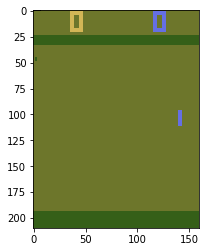

In [5]:
plt.figure()
plt.imshow(env.render(mode='rgb_array'))

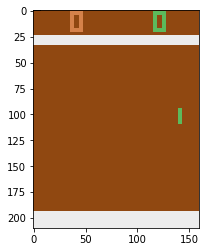

In [15]:
env.reset
env.step(4)
env.step(2)
env.step(3)
plt.figure()
plt.imshow(env.render(mode='rgb_array'))

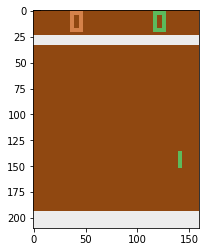

In [7]:
env.reset()
[env.step(3) for x in range(4)]
plt.figure()
plt.imshow(env.render(mode='rgb_array'))

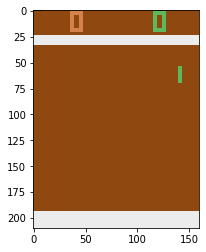

In [8]:
env.reset()
[env.step(2) for x in range(4)]
plt.figure()
plt.imshow(env.render(mode='rgb_array'))

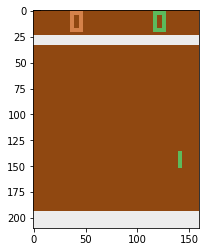

In [9]:
env.reset()
[env.step(5) for x in range(4)]
plt.figure()
plt.imshow(env.render(mode='rgb_array'))

In [10]:
def process(screen):
    screen=screen[34:194,0:160]
    
    pscreen = t.Compose([t.ToPILImage()])(screen)
    pscreen = t.Compose([t.Grayscale()])(pscreen)
    pscreen = t.Compose([t.Resize((84,84))])(pscreen)
    pscreen = t.Compose([t.ToTensor()])(pscreen)
    
    return pscreen.unsqueeze(0)

In [11]:
screen=env.reset()
pscreen=process(screen)

In [12]:
pscreen

tensor([[[[0.4157, 0.4157, 0.4157,  ..., 0.4157, 0.4157, 0.4157],
          [0.4157, 0.4157, 0.4157,  ..., 0.4157, 0.4157, 0.4157],
          [0.4157, 0.4157, 0.4157,  ..., 0.4157, 0.4157, 0.4157],
          ...,
          [0.4157, 0.4157, 0.4157,  ..., 0.4157, 0.4157, 0.4157],
          [0.4157, 0.4157, 0.4157,  ..., 0.4157, 0.4157, 0.4157],
          [0.4157, 0.4157, 0.4157,  ..., 0.4157, 0.4157, 0.4157]]]])

In [13]:
pscreen.shape

torch.Size([1, 1, 84, 84])

In [14]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1=nn.Sequential(nn.Conv2d(4, 32, kernel_size=8, stride=4),nn.ReLU())       
        self.conv2=nn.Sequential(nn.Conv2d(32, 64, kernel_size=8, stride=4),nn.ReLU())   
        self.conv3=nn.Sequential(nn.Conv2d(64,64, kernel_size=8, stride=4),nn.ReLU())        
        self.dense=torch.nn.Linear(64*7*7,512)
        self.r4=nn.ReLU()
        self.out=torch.nn.Linear(512,4)
        
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                 nn.init.kaiming_normal_(m.weight,nonlinearity = 'relu')

        
                    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
    
        x = x.view(x.size(0),-1)
        x=self.dense(x)
        x = self.r4(x)
        x = self.out(x)
        return x

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
device

device(type='cuda')

In [ ]:
policy_net = DQN().to(device)
target_net = DQN().to(device)


In [ ]:
target_net.load_state_dict(policy_net.state_dict())

In [ ]:
target_net.modules()

In [49]:
optimizer = optim.RMSprop(policy_net.parameters(),lr= 0.00005, eps=0.01, alpha=0.95)




In [ ]:
from collections import namedtuple
Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])


In [ ]:
state = env.reset()
state = process(state)
state = torch.cat(tuple([state] * 4), dim=1)
print(state.shape)


In [ ]:
from lib import plotting

In [ ]:
from itertools import count

In [ ]:
def learn(env,num_episodes,experiment_dir,replay_memory_size=500000,replay_memory_init_size=50000,update_target_estimator_every=10000,discount_factor=0.99,epsilon_start=1.0,epsilon_end=0.1,epsilon_decay_steps=500000,batch_size=32,
record_video_every=50):
    replay_memory = []
    # Keeps track of useful statistics
#     stats = plotting.EpisodeStats(
#         episode_lengths=np.zeros(num_episodes),
#         episode_rewards=np.zeros(num_episodes))
    
#     experiment_dir,replay_memory_size=500000,
#     replay_memory_init_size=50000,update_target_estimator_every=10000,discount_factor=0.99,
#     epsilon_start=1.0,epsilon_end=0.1,epsilon_decay_steps=500000,batch_size=32,
# record_video_every=50):
    
    episode_lengths=np.zeros(num_episodes)
    episode_rewards=np.zeros(num_episodes)
   
    num_steps = 0
    state = env.reset()
    state = process(state)
    state = torch.cat(tuple([state] * 4), dim=1)
    
    def e_greedy_action():
        sample = random.random()
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * num_steps / epsilon_decay_steps)
        if sample > epsilon:
            with torch.no_grad():
                return (policy_net(((torch.from_numpy(state)).float()/255).to(device)).max(1)[1].data[0])
        else:
            return random.randrange(4)
        
    for i in range(replay_memory_init_size):
        action = e_greedy_action()
        next_state, reward, done, _ = env.step(action)
        next_state = process(next_state)
        next_state = np.concatenate((state[:,1:,:,:],next_state), axis=1)
        replay_memory.append(Transition(state, [[int(action)]],[reward], next_state, [not done]))
        if done:
            state = env.reset()
            state = process(state)
            state = np.concatenate([state] * 4, axis = 1)
        else:
            state = next_state

    for i_episode in range(num_episodes):
        state = env.reset()
        state = process(state)
        state = np.concatenate([state] * 4, axis = 1)
        loss = None
        for t in count():
            if num_steps % update_target_estimator_every == 0:
                target_net.load_state_dict(policy_net.state_dict())

            action = e_greedy_action()
            next_state, reward, done, _ = env.step(action)
            num_steps+=1
            next_state = process(next_state)
            next_state = np.concatenate((state[:,1:,:,:],next_state), axis=1)

            if len(replay_memory) == replay_memory_size:
                replay_memory.pop(0)
            replay_memory.append(Transition(state, [[int(action)]],[reward], next_state, [not done]))
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] +=1
            if(num_steps%4==0):
                transitions = random.sample(replay_memory, batch_size)
                for i,t in enumerate(transitions):
                    transitions[i] = Transition(torch.tensor(t.state, device= device, dtype = torch.float)/255,torch.tensor(t.action, device= device, dtype = torch.long), torch.tensor(t.reward, device= device, dtype = torch.float), torch.tensor(t.next_state, device= device, dtype = torch.float)/255 , torch.tensor(t.done, device= device, dtype = torch.float))
                batch = Transition(*zip(*transitions))
                state_batch = (torch.cat(batch.state))
                action_batch = (torch.cat(batch.action))                
                reward_batch = torch.cat(batch.reward)  
                next_state_batch = torch.cat(batch.next_state)
                done_batch = torch.cat(batch.done) 
                state_action_values = policy_net(state_batch).gather(1, action_batch)
                q_next_batch = target_net(next_state_batch).max(1)[0].detach()
                target_batch = reward_batch + discount_factor*done_batch*q_next_batch
                loss = F.smooth_l1_loss(state_action_values, target_batch.unsqueeze(1))
                optimizer.zero_grad()
                loss.backward()
                for param in policy_net.parameters():
                      param.grad.data.clamp_(-1, 1)
                optimizer.step()
            state = next_state
            if done:
                break
            if i_episode % 100 == 0:
                    gc.collect()
            if(i_episode%1000):
                torch.save({
                    'episode' : i_episode//1000+1,
                    'state_dict' : policy_net.state_dict(),
                    'optimizer' : optimizer.state_dict()},
                    'dqn{}.model'.format(i_episode//1000+1))

                
        yield num_steps, plotting.EpisodeStats(
            episode_lengths=stats.episode_lengths[:i_episode+1],
            episode_rewards=stats.episode_rewards[:i_episode+1])

    return stats


In [ ]:
experiment_dir = os.path.abspath("./experiments/{}".format(env.spec.id))
i = 0
reward = 0
rewards = []
for t, stats in learn(env,num_episodes=3,experiment_dir=experiment_dir,replay_memory_size=1000000,replay_memory_init_size=50000,update_target_estimator_every=10000,discount_factor=0.99,epsilon_start=1.0,epsilon_end=0.1,epsilon_decay_steps=1000000,batch_size=32,record_video_every=100):
        reward+=stats.episode_rewards[-1]
        if(i%100==0):
            print("\nEpisode Reward: {}".format(reward/100))
            rewards.append(reward/100)
            reward = 0
        i+=1
        if(i%5000==0):
            np.save("reward{}.npy".format(i//5000),np.array(rewards))
        
        